In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import networkx as nx
from utils import SIR_net_adaptive
import utils
import multiprocessing as mp
import time

Testing the effect of rewiring in the information network

In [21]:
N = 1000 # number of nodes
ave_degree = 10
p = ave_degree / N  # edge probability
initial_infecteds = np.random.choice(np.arange(N), size=5, replace=False)
initial_no_vax = np.arange(100, 300)
#initial_no_vax = 300

mu = 1 / 7       # recovery rate
beta = 3 / 140    # infection rate
pro = 0.      # rate of classical media influence on people
pol = 0.3      # propensity of opinion polarization
r = 0.1        # rate of vaccination for PV
#gamma = 0.5
#nmax = 100

G_phys = nx.barabasi_albert_graph(N, int(ave_degree/2))
G_info_static = G_phys.copy()
#utils.initNET_SI(G_info_static, I0=initial_no_vax, I_seed=np.arange(10)) # initialize information network
utils.initNET_rnd(G_info_static, initial_no_vax)
G_info_dynamic = G_info_static.copy()


sim_static = SIR_net_adaptive(G_phys, G_info_static, beta=beta, mu=mu, r=r, pro=pro, pol=pol, initial_infecteds=initial_infecteds, rewiring=False)
sim_dynamic = SIR_net_adaptive(G_phys, G_info_dynamic, beta=beta, mu=mu, r=r, pro=pro, pol=pol, initial_infecteds=initial_infecteds)

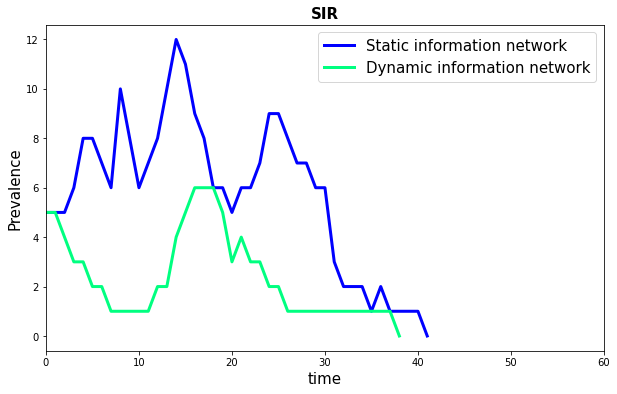

In [22]:
colors = cm.get_cmap('winter', 2)
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(10,6))
ax.plot(sim_static[0], sim_static[2], lw=3, c=colors(0), label= "Static information network", alpha=1)
ax.plot(sim_dynamic[0], sim_dynamic[2], lw=3, c=colors(1), label= "Dynamic information network", alpha=1)
ax.set_title('SIR', fontweight='bold', size=15)
ax.legend(fontsize=15)
ax.set_ylabel("Prevalence", size=15)
ax.set_xlabel("time", size=15)
ax.set_xlim(0, 60);

infoNET clustering coefficients:
static: 0.037373457645105426
dynamic: 0.10790089978496542


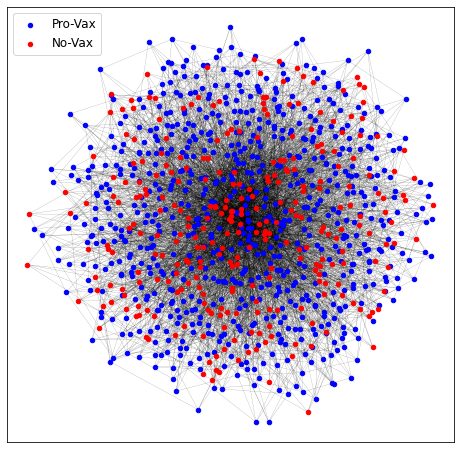

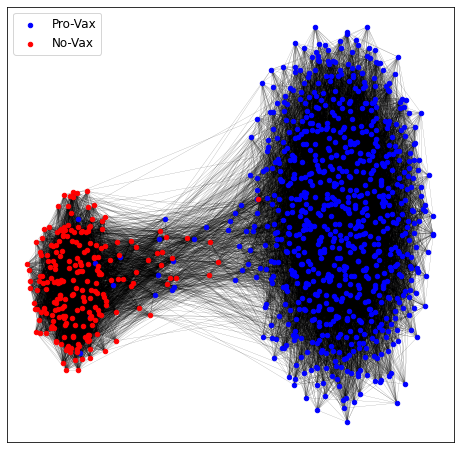

In [23]:
print('infoNET clustering coefficients:')
print('static:', nx.algorithms.cluster.average_clustering(G_info_static))
print('dynamic:', nx.algorithms.cluster.average_clustering(G_info_dynamic))
utils.plot_info_network(G_info_static)
utils.plot_info_network(G_info_dynamic)

Da quì in poi non va, bisogna riadattarlo alla funzione SIR_net_adaptive

In [8]:
# Some more statistics
def sim_prevalence():
    N = 1000 # number of nodes
    ave_degree = 15
    initial_infecteds = np.random.choice(np.arange(N), size=5, replace=False)
    initial_no_vax = np.arange(100,300)


    mu = 0.1       # recovery rate
    beta = 0.15    # infection rate
    pro = 0.      # rate of classical media influence on people
    pol = 0.5      # propensity of opinion polarization
    r = 0.3       # rate of vaccination for PV

    G_phys = nx.barabasi_albert_graph(N, int(ave_degree/2))
    G_info_static = G_phys.copy()
    utils.initNET_rnd(G_info_static, initial_no_vax)
    G_info_dynamic = G_info_static.copy()
    seed = np.random.randint(time.time())

    sim_static = SIR_net_adaptive(G_phys, G_info_static, beta=beta, mu=mu, r=r, pro=pro, pol=pol, initial_infecteds=initial_infecteds, rewiring=False, message=False, rng=np.random.default_rng(seed))
    sim_dynamic = SIR_net_adaptive(G_phys, G_info_dynamic, beta=beta, mu=mu, r=r, pro=pro, pol=pol, initial_infecteds=initial_infecteds, message=False, rng=np.random.default_rng(seed))
    print('simulation completed')
    return (sim_static, sim_dynamic)

In [9]:
nsim = 12
answers = []
pool = mp.Pool(mp.cpu_count())

results = [pool.apply_async(sim_prevalence) for _ in range(nsim)]
answers = [res.get(timeout=180) for res in results]
pool.close()

simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed


In [10]:
answers = np.array(answers, dtype=object)
static_I = answers[:, 0, [0,2]]
dynamic_I = answers[:, 1, [0,2]]
minlen_static_I = min(list(map(len, static_I[:,1])))
minlen_dynamic_I = min(list(map(len, dynamic_I[:,1])))
ave_I_stat = np.mean([static_I[i,1][:minlen_static_I] for i in range(nsim)], axis=0)
ave_I_dyn = np.mean([dynamic_I[i,1][:minlen_dynamic_I] for i in range(nsim)], axis=0)

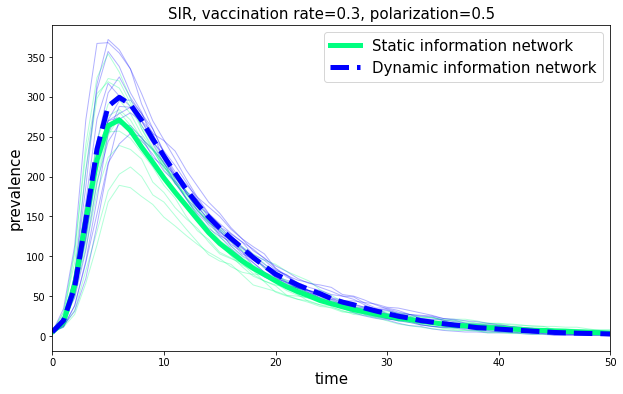

In [11]:
r = 0.3
pol = 0.5
colors = cm.get_cmap('winter', 2)
plt.figure(figsize=(10,6))
plt.title(f'SIR, vaccination rate={r}, polarization={pol}', size=15)
plt.xlabel('time', size=15)
plt.ylabel('prevalence', size=15)
for curve1, curve2 in zip(static_I, dynamic_I):
    plt.plot(curve1[0], curve1[1], c=colors(1), lw=1, alpha=0.3)
    plt.plot(curve2[0], curve2[1], c=colors(0), lw=1, alpha=0.3)
plt.plot(np.arange(minlen_static_I), ave_I_stat, lw=5, c=colors(1), label='Static information network')
plt.plot(np.arange(minlen_dynamic_I), ave_I_dyn, lw=5, c=colors(0), label='Dynamic information network', ls='dashed')
plt.legend(loc='best', fontsize=15)
plt.xlim(0,50)
plt.savefig(f'./plots/SIR_r{r}_pol{pol}_v1.png')

### Prove